In [1]:
import xarray as xr
import pandas as pd
from glob import glob
from datetime import datetime as dt
import numpy as np
from numba import njit

from matplotlib import pyplot as plt
from matplotlib import dates as pltdates
from metpy.plots import SkewT
from metpy import calc as mpcalc
from metpy.plots import USCOUNTIES
from metpy.units import units as un
from cartopy import crs as ccrs
from cartopy import feature as cfeat


px = 1/plt.rcParams['figure.dpi']

In [2]:
@njit
def identify_side(dts, lons, lats, tfm_times, seabreeze, grid_lon, grid_lat):
    seabreezes = np.zeros(lons.shape)
    for i in np.arange(seabreezes.shape[0]):
        lon = lons[i]
        lat = lats[i]
        this_dt = dts[i]
        closest_time_idx = np.argmin(np.abs(tfm_times - this_dt))
        dist_idx_raveled = np.argmin(((grid_lon - lon)**2 + (grid_lat - lat)**2)**0.5)
        # dist_idx = np.unravel_index(distance.compute(), distance.shape)
        # Manually implement unravel_index since it isn't supported by numba
        closest_row_idx = dist_idx_raveled // grid_lon.shape[1]
        closest_col_idx = dist_idx_raveled % grid_lon.shape[1]
        closest_seabreeze = seabreeze[closest_time_idx, closest_row_idx, closest_col_idx]
        seabreezes[i] = closest_seabreeze
    return seabreezes

In [3]:
date_i_want = dt(2022, 6, 2)
tfm_path = f'/Volumes/LtgSSD/tobac_saves/tobac_Save_{date_i_want.strftime("%Y%m%d")}/seabreeze-obs.zarr'
tfm = xr.open_dataset(tfm_path, engine='zarr')

In [4]:
tfm

<xarray.Dataset> Size: 32GB
Dimensions:                           (feature: 16210, cell: 945, time: 283,
                                       vertical_levels: 2000, x: 1001, y: 1001,
                                       track: 770)
Coordinates:
  * cell                              (cell) int64 8kB -1 4 6 ... 5092 5107 5110
  * feature                           (feature) int64 130kB 1 2 ... 16209 16210
  * time                              (time) datetime64[ns] 2kB 2022-06-02T00...
  * track                             (track) float64 6kB 0.0 1.0 ... 769.0
  * vertical_levels                   (vertical_levels) int64 16kB 0 1 ... 1999
  * x                                 (x) float64 8kB -2.5e+05 ... 2.5e+05
  * y                                 (y) float64 8kB -2.5e+05 ... 2.5e+05
Data variables: (12/98)
    avg_L2-MCMIPC                     (feature) float64 130kB ...
    cell_child_feature_count          (cell) float64 8kB ...
    cell_parent_track_id              (cell) float64 8kB ...
    continental_ccn_profile           (time, vertical_levels) float64 5MB ...
    continental_dewpoint_profile      (time, vertical_levels) float64 5MB ...
    continental_msl_profile           (time, vertical_levels) float64 5MB ...
    ...                                ...
    track_rhvdeficitvol               (track, time) float64 2MB ...
    track_seabreeze                   (track, time) float64 2MB ...
    track_temp_profile                (track, time, vertical_levels) float64 3GB ...
    track_u_profile                   (track, time, vertical_levels) float64 3GB ...
    track_v_profile                   (track, time, vertical_levels) float64 3GB ...
    track_zdrvol                      (track, time) float64 2MB ...
Attributes:
    center_lat:      29.47
    center_lon:      -95.08
    soundings_used:  ['housondewnpnM1.b1.20220602.053000.cdf', 'housondewnpnM...

In [5]:
start_time = date_i_want.replace(hour=12)
end_time = date_i_want.replace(hour=23, minute=59, second=59)
times_i_want = tfm.time.sel(time=slice(start_time, end_time)).data
max_time_idx = times_i_want.shape[0]
for i, time in enumerate(times_i_want):
    print(f'{i/max_time_idx*100:.2f}%')
    this_time = tfm.sel(time=time)
    for airmass in ['Continental', 'Maritime']:
        p = this_time[f'{airmass.lower()}_pressure_profile'].data * un.hPa
        T = this_time[f'{airmass.lower()}_temperature_profile'].data * un.degC
        Td = this_time[f'{airmass.lower()}_dewpoint_profile'].data * un.degC
        u = this_time[f'{airmass.lower()}_u_profile'].data * un.meter / un.second
        v = this_time[f'{airmass.lower()}_v_profile'].data * un.meter / un.second
        
        mask = mpcalc.resample_nn_1d(p.m,  np.logspace(4, 2))
        
        fig = plt.figure()
        skew = SkewT(fig)
        skew.plot(p, T, 'r')
        skew.plot(p, Td, 'lime')
        skew.ax.scatter([T[0]], [p[0]], color='r', s=10, edgecolors='k', zorder=5)
        skew.ax.scatter([Td[0]], [p[0]], color='lime', s=10, edgecolors='k', zorder=5)
        skew.plot_barbs(p[mask], u[mask], v[mask])

        skew.ax.set_title(f'{airmass} Representative Profile\n{time.astype('datetime64[m]').astype('O').strftime('%Y-%m-%d %H:%M')}')
        fig.set_size_inches(512*px, 512*px)
        fig.savefig(f'./agu_figs/wiggle_sounding/{airmass}/{str(i).zfill(4)}.png')
        plt.close(fig)

0.00%
0.61%


1.23%
1.84%
2.45%
3.07%
3.68%
4.29%
4.91%
5.52%
6.13%
6.75%
7.36%
7.98%
8.59%
9.20%
9.82%
10.43%
11.04%
11.66%
12.27%
12.88%
13.50%
14.11%
14.72%
15.34%
15.95%
16.56%
17.18%
17.79%
18.40%
19.02%
19.63%
20.25%
20.86%
21.47%
22.09%
22.70%
23.31%
23.93%
24.54%
25.15%
25.77%
26.38%
26.99%
27.61%
28.22%
28.83%
29.45%
30.06%
30.67%
31.29%
31.90%
32.52%
33.13%
33.74%
34.36%
34.97%
35.58%
36.20%
36.81%
37.42%
38.04%
38.65%
39.26%
39.88%
40.49%
41.10%
41.72%
42.33%
42.94%
43.56%
44.17%
44.79%
45.40%
46.01%
46.63%
47.24%
47.85%
48.47%
49.08%
49.69%
50.31%
50.92%
51.53%
52.15%
52.76%
53.37%
53.99%
54.60%
55.21%
55.83%
56.44%
57.06%
57.67%
58.28%
58.90%
59.51%
60.12%
60.74%
61.35%
61.96%
62.58%
63.19%
63.80%
64.42%
65.03%
65.64%
66.26%
66.87%
67.48%
68.10%
68.71%
69.33%
69.94%
70.55%
71.17%
71.78%
72.39%
73.01%
73.62%
74.23%
74.85%
75.46%
76.07%
76.69%
77.30%
77.91%
78.53%
79.14%
79.75%
80.37%
80.98%
81.60%
82.21%
82.82%
83.44%
84.05%
84.66%
85.28%
85.89%
86.50%
87.12%
87.73%
88.34%
88.96%
89.57%


In [6]:
tfm.continental_ccn_profile.isel(vertical_levels=0).sel(time=slice(start_time, end_time))

<xarray.DataArray 'continental_ccn_profile' (time: 163)> Size: 1kB
[163 values with dtype=float64]
Coordinates:
  * time             (time) datetime64[ns] 1kB 2022-06-02T12:03:30.591000064 ...
    vertical_levels  int64 8B 0

In [7]:

arm_ccn_path = '/Volumes/LtgSSD/arm-ccn-avg/'
arm_ccn_files = glob(arm_ccn_path+date_i_want.strftime('*%Y%m%d*.nc'))
maritime_ccn = []
maritime_times = []
continental_ccn = []
continental_times = []
if len(arm_ccn_files) == 1:
    arm_ccn_file = arm_ccn_files[0]
    arm_ccn = xr.open_dataset(arm_ccn_file)
    arm_ccn_ccn = arm_ccn.N_CCN.data
    arm_ccn_time = arm_ccn.time.data
    readings_in_window = ((arm_ccn.supersaturation_calculated >= 0.6) & (arm_ccn.supersaturation_calculated <= 0.8))
    arm_ccn_ccn_window = arm_ccn_ccn[readings_in_window]
    arm_ccn_time_window = arm_ccn_time[readings_in_window]
    arm_ccn_lon = np.full(arm_ccn_time_window.shape, arm_ccn.lon.data)
    arm_ccn_lat = np.full(arm_ccn_time_window.shape, arm_ccn.lat.data)
    arm_ccn_sbf = identify_side(arm_ccn_time_window.astype('datetime64[s]').astype(float), arm_ccn_lon, arm_ccn_lat, tfm.time.compute().data.astype('datetime64[s]').astype(float),
                                        tfm.seabreeze.transpose('time', *tfm.lat.dims).compute().data, tfm.lon.compute().data, tfm.lat.compute().data)
    
    arm_ccn_maritime = arm_ccn_ccn_window[arm_ccn_sbf == -1]
    arm_maritime_time = arm_ccn_time_window[arm_ccn_sbf == -1]
    maritime_ccn.extend(arm_ccn_maritime.tolist())
    maritime_times.extend(arm_maritime_time.tolist())
    arm_ccn_continental = arm_ccn_ccn_window[arm_ccn_sbf == -2]
    arm_continental_time = arm_ccn_time_window[arm_ccn_sbf == -2]
    continental_ccn.extend(arm_ccn_continental.tolist())
    continental_times.extend(arm_continental_time.tolist())
else:
    print(f'Warning, {len(arm_ccn_files)} ARM CCN files found!')
tamu_ccn_path = '/Volumes/LtgSSD/brooks-ccn/'
tamu_ccn_files = glob(tamu_ccn_path+date_i_want.strftime('*%y%m%d_ccn*.csv'))
if len(tamu_ccn_files) == 1:
    tamu_ccn_file = tamu_ccn_files[0]
    tamu_ccn = pd.read_csv(tamu_ccn_file)
    tamu_ccn = tamu_ccn[tamu_ccn['SS'] == 0.6]
    tamu_times_window = pd.to_datetime(tamu_ccn.loc[:, 'Time'], format='%y%m%d %H:%M:%S').values
    tamu_ccn_window = tamu_ccn.loc[:, 'N_CCN'].values
    tamu_ccn_lon_window = tamu_ccn.loc[:, 'Longitude'].values
    tamu_ccn_lat_window = tamu_ccn.loc[:, 'Latitude'].values
    tamu_ccn_sbf = identify_side(tamu_times_window, tamu_ccn_lon_window, tamu_ccn_lat_window, tfm)
    tamu_ccn_maritime = tamu_ccn_window[tamu_ccn_sbf == -1]
    tamu_maritime_time = tamu_times_window[tamu_ccn_sbf == -1]
    maritime_ccn.extend(tamu_ccn_maritime.tolist())
    maritime_times.extend(tamu_maritime_time.tolist())
    tamu_ccn_continental = tamu_ccn_window[tamu_ccn_sbf == -2]
    tamu_continental_time = tamu_times_window[tamu_ccn_sbf == -2]
    continental_ccn.extend(tamu_ccn_continental.tolist())
    continental_times.extend(tamu_continental_time.tolist())
else:
    print(f'Warning, {len(tamu_ccn_files)} TAMU CCN files found!')
continental_sorting = np.argsort(continental_times)
continental_times = np.array(continental_times)[continental_sorting]
continental_ccn = np.array(continental_ccn)[continental_sorting]
maritime_sorting = np.argsort(maritime_times)
maritime_times = np.array(maritime_times)[maritime_sorting]
maritime_ccn = np.array(maritime_ccn)[maritime_sorting]

Warning, 0 TAMU CCN files found!


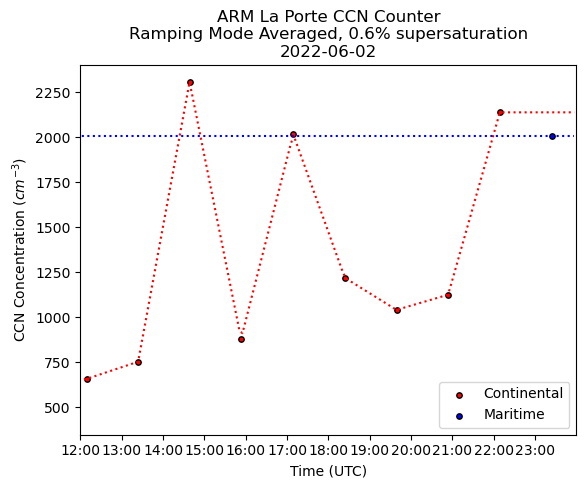

In [8]:
aerosol_example_fig = plt.figure()
ax = aerosol_example_fig.gca()
ax.scatter(arm_continental_time, arm_ccn_continental, label='Continental', s=15, color='r', edgecolors='k')
ax.scatter(arm_maritime_time, arm_ccn_maritime, label='Maritime', s=15, color='b', edgecolors='k')
ax.plot(tfm.time, tfm.continental_ccn_profile.isel(vertical_levels=0), color='r', linestyle=':')
ax.plot(tfm.time, tfm.maritime_ccn_profile.isel(vertical_levels=0), color='b', linestyle=':')
ax.set_xlim(start_time, end_time)
ax.set_ylabel(r'CCN Concentration ($cm^{-3}$)')
ax.set_xlabel('Time (UTC)')
ax.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M'))
ax.set_title(f'ARM La Porte CCN Counter\nRamping Mode Averaged, 0.6% supersaturation\n{date_i_want.strftime("%Y-%m-%d")}')
ax.legend(loc='lower right')

/var/folders/sp/1j_lh9313dg42jrzhsfb4mk40000gn/T/ipykernel_50530/2750746576.py:9: RuntimeWarning: Mean of empty slice
  this_track_sbf = np.nanmean(this_track_ds.track_seabreeze.data)


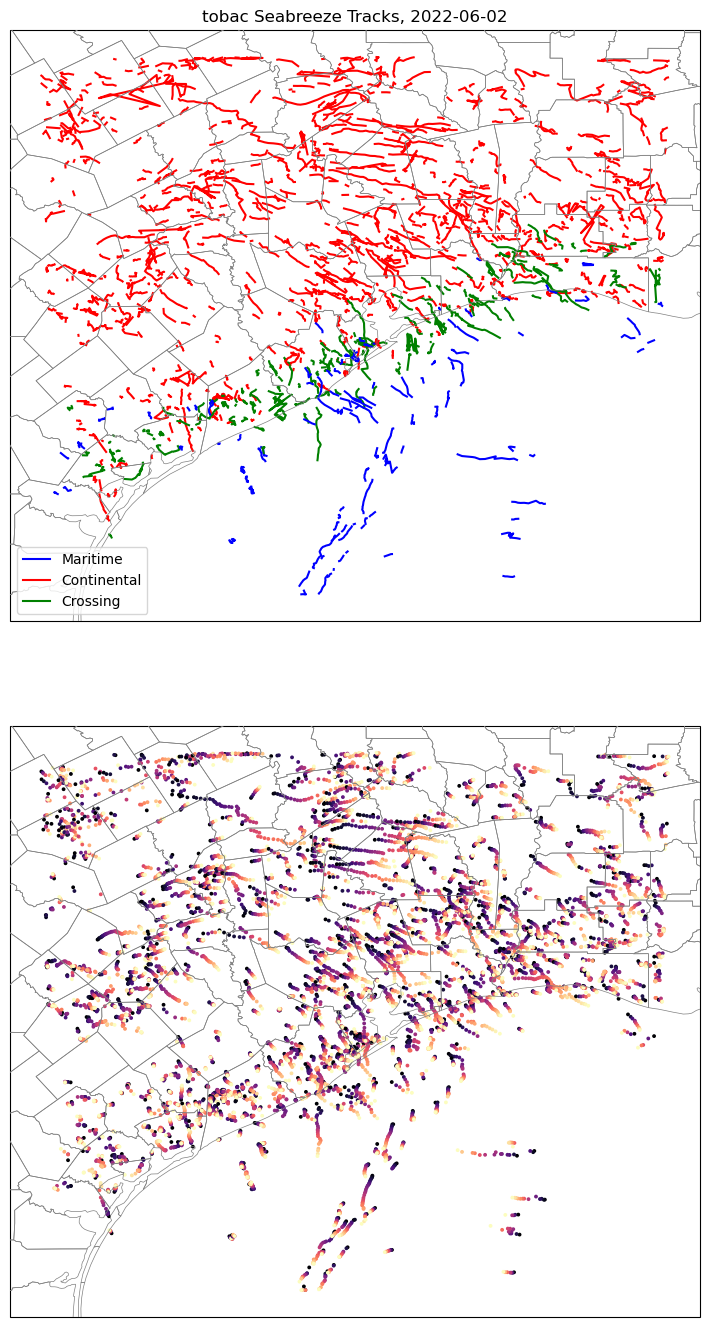

In [9]:
track_fig, (track_ax, points_ax) = plt.subplots(2, 1, subplot_kw={'projection': ccrs.PlateCarree()})
# track_ax = plt.axes(projection=ccrs.PlateCarree())
mar_art = None
cont_art = None
cross_art = None
for this_track in tfm.track:
    this_track_ds = tfm.sel(track=this_track)
    points_ax.scatter(this_track_ds.track_lon, this_track_ds.track_lat, c=this_track_ds.time, cmap='magma', s=3, zorder=3)
    this_track_sbf = np.nanmean(this_track_ds.track_seabreeze.data)
    if this_track_sbf == -1:
        mar_art, = track_ax.plot(this_track_ds.track_lon, this_track_ds.track_lat, c='b', label='Maritime', zorder=2)
    elif this_track_sbf == -2:
        cont_art, = track_ax.plot(this_track_ds.track_lon, this_track_ds.track_lat, c='r', label='Continental', zorder=2)
    else:
        cross_art, = track_ax.plot(this_track_ds.track_lon, this_track_ds.track_lat, c='g', label='Crossing', zorder=2)
track_ax.add_feature(USCOUNTIES.with_scale('5m'), zorder=3, edgecolor='gray', linewidth=0.5)
points_ax.add_feature(USCOUNTIES.with_scale('5m'), zorder=3, edgecolor='gray', linewidth=0.5)
track_ax.legend(handles=(mar_art, cont_art, cross_art), labels=('Maritime', 'Continental', 'Crossing'))
track_ax.set_title(f'tobac Seabreeze Tracks, {date_i_want.strftime("%Y-%m-%d")}')
track_fig.set_size_inches(720*px, 2*720*px)
track_fig.tight_layout()


In [10]:
all_sbf_obs = glob('/Volumes/LtgSSD/tobac_saves/tobac_Save_*/seabreeze-obs.zarr')

In [11]:
ds1 = xr.open_dataset(all_sbf_obs[0], engine='zarr')
ds2 = xr.open_dataset(all_sbf_obs[1], engine='zarr')

In [12]:
track_ds = []
track_day = []
track_ccn = []
track_ecape = []
track_echotop = []
track_cloudtop = []

track_flash_count = []
track_kdp_vol = []
track_zdr_vol = []

track_seabreeze = []

for i, ds_path in enumerate(all_sbf_obs):
    this_ds = xr.open_dataset(ds_path, engine='zarr')
    track_ds.extend([i]*this_ds.track.shape[0])
    this_track_day = this_ds.time.data[0].astype('datetime64[D]').astype('O')
    track_day.extend([this_track_day]*this_ds.track.shape[0])
    track_ccn.extend(this_ds.track_ccn_profile.isel(vertical_levels=0).mean(dim='time').data)
    track_ecape.extend(this_ds.track_mlecape.mean(dim='time').data)
    track_echotop.extend(this_ds.track_echo_top.max(dim='time').data/1000)
    track_cloudtop.extend(this_ds.track_min_L2_MCMIPC.min(dim='time').data - 273.15)

    track_flash_count.extend(this_ds.track_flash_count.sum(dim='time').data)
    track_kdp_vol.extend(this_ds.track_kdpvol.sum(dim='time').data)
    track_zdr_vol.extend(this_ds.track_zdrvol.sum(dim='time').data)
    track_seabreeze.extend(this_ds.track_seabreeze.mean(dim='time').data)

In [13]:
track_ds = np.array(track_ds)
track_day = np.array(track_day)
track_ccn = np.array(track_ccn)
track_ecape = np.array(track_ecape)
track_echotop = np.array(track_echotop)
track_cloudtop = np.array(track_cloudtop)

track_flash_count = np.array(track_flash_count)
track_kdp_vol = np.array(track_kdp_vol)
track_zdr_vol = np.array(track_zdr_vol)

track_seabreeze = np.array(track_seabreeze)

tracks_df = pd.DataFrame({
    'dataset_id' : track_ds,
    'track_day' : track_day,
    'track_ccn' : track_ccn,
    'track_ecape' : track_ecape,
    'track_echotop' : track_echotop,
    'track_cloudtop' : track_cloudtop,
    'track_flash_count' : track_flash_count,
    'track_kdp_vol' : track_kdp_vol,
    'track_zdr_vol' : track_zdr_vol,
    'track_seabreeze' : track_seabreeze
})

In [14]:
tracks_df

,dataset_id,track_day,track_ccn,track_ecape,track_echotop,track_cloudtop,track_flash_count,track_kdp_vol,track_zdr_vol,track_seabreeze
0,0,2022-06-02,NaN,NaN,NaN,NaN,0.000000,0.000,0.000,NaN
1,0,2022-06-02,439.451843,1182.644090,11.0,-56.664844,0.000000,0.000,0.000,-2.0
2,0,2022-06-02,445.863768,1182.644090,9.5,-42.456818,93.780723,2295.375,5072.125,-2.0
3,0,2022-06-02,453.933670,1182.644090,14.5,-61.135311,136.971429,1689.250,5822.000,-2.0
4,0,2022-06-02,458.015622,1182.644090,13.0,-49.815580,80.129611,919.500,5554.125,-2.0
...,...,...,...,...,...,...,...,...,...,...
943,1,2022-06-16,2416.389404,886.428292,14.5,-68.143236,15.148515,226.375,225.125,-2.0
944,1,2022-06-16,2416.389404,886.328282,6.5,-66.533694,0.000000,0.000,11.750,-2.0
945,1,2022-06-16,2416.389404,886.315334,14.5,-56.494813,145.661619,432.875,460.250,-2.0
946,1,2022-06-16,2416.389404,886.379322,7.0,21.139975,0.000000,0.000,0.000,-2.0


In [15]:
labels = ['Nothing', r'$Z_{DR}$', r'$K_{DP}$', r'$Z_{DR}$ $K_{DP}$', r'$Z_{DR}$ Lightning', r'$K_{DP}$ Lightning', r'$Z_{DR}$ $K_{DP}$ Lightning', 'Lightning']
for i, side in enumerate(['Continental', 'Maritime', 'Crossing']):
    fig, ax = plt.subplots()
    i -= 2
    if i == 0:
        track_df_side = tracks_df[(tracks_df['track_seabreeze'] > -2) & (tracks_df['track_seabreeze'] < -1)]
    else:
        track_df_side = tracks_df[tracks_df['track_seabreeze'] == i]
    days = []
    ntrackss = []
    nothing_fracs = []
    zdr_fracs = []
    kdp_fracs = []
    zdr_kdp_fracs = []
    zdr_lightning_fracs = []
    kdp_lightning_fracs = []
    everything_fracs = []
    lightning_fracs = []

    for i, day in enumerate(track_df_side['track_day'].unique()):
        tds = track_df_side[track_df_side['track_day'] == day]
        n_tracks = tds.shape[0]
        ntrackss.append(n_tracks)
        has_lightning = tds['track_flash_count'] > 0
        has_kdp = tds['track_kdp_vol'] > 0
        has_zdr = tds['track_zdr_vol'] > 0
        nothing_tracks = tds[~has_lightning & ~has_kdp & ~has_zdr]
        kdp_tracks = tds[~has_lightning & has_kdp & ~has_zdr]
        zdr_tracks = tds[~has_lightning & ~has_kdp & has_zdr]
        zdr_kdp_tracks = tds[~has_lightning & has_kdp & has_zdr]
        zdr_lightning_tracks = tds[has_lightning & ~has_kdp & has_zdr]
        kdp_lightning_tracks = tds[has_lightning & has_kdp & ~has_zdr]
        everything_tracks = tds[has_lightning & has_kdp & has_zdr]
        lightning_tracks = tds[has_lightning & ~has_kdp & ~has_zdr]

        for scatter_ind, xlabel in zip(['track_ccn', 'track_ecape', 'track_echotop', 'track_cloudtop'],
                                       [r'N CCN ($cm^{-3}$)', 'Mixed-Layer Entraining CAPE (J/kg)', '18 dBZ Echo Top (km)', 'Cloud Top (°C)']):
            compfig, compax = plt.subplots()
            compax.scatter(nothing_tracks[scatter_ind], nothing_tracks['track_flash_count'], label=labels[0], marker='o')
            compax.scatter(zdr_tracks[scatter_ind], zdr_tracks['track_flash_count'], label=labels[1], marker='+')
            compax.scatter(kdp_tracks[scatter_ind], kdp_tracks['track_flash_count'], label=labels[2], marker='^')
            compax.scatter(zdr_kdp_tracks[scatter_ind], zdr_kdp_tracks['track_flash_count'], label=labels[3], marker='x')
            compax.scatter(zdr_lightning_tracks[scatter_ind], zdr_lightning_tracks['track_flash_count'], label=labels[4], marker='4')
            compax.scatter(kdp_lightning_tracks[scatter_ind], kdp_lightning_tracks['track_flash_count'], label=labels[5], marker='8')
            compax.scatter(everything_tracks[scatter_ind], everything_tracks['track_flash_count'], label=labels[6], marker='>')
            compax.scatter(lightning_tracks[scatter_ind], lightning_tracks['track_flash_count'], label=labels[7], marker='s')
            compax.set_title(f'{side} tracks for {day.strftime("%Y-%m-%d")}')
            compax.set_xlabel(xlabel)
            compax.set_ylabel('Track Accumulated Flash Count')
            compfig.set_size_inches(720*px, 720*px)
            compfig.tight_layout()
            compfig.savefig(f'./agu_figs/track_scatters/{day.strftime("%Y-%m-%d")}_{side}_{scatter_ind}.png')
            plt.close(compfig)

        totals = [nothing_tracks.shape[0], zdr_tracks.shape[0], kdp_tracks.shape[0], zdr_kdp_tracks.shape[0], zdr_lightning_tracks.shape[0],
                  kdp_lightning_tracks.shape[0], everything_tracks.shape[0], lightning_tracks.shape[0]]
        for i, thing_to_update in enumerate([nothing_fracs, zdr_fracs, kdp_fracs, zdr_kdp_fracs, zdr_lightning_fracs, kdp_lightning_fracs, everything_fracs, lightning_fracs]):
            thing_to_update.append(totals[i] / n_tracks)
        days.append(day)
    day_strs = [day.strftime('%Y-%m-%d\nTracks: ')+str(tot) for day, tot in zip(days, ntrackss)]
    nothing = ax.bar(day_strs, nothing_fracs, label=labels[0])
    bottomsum = np.array(nothing_fracs)
    zdr = ax.bar(day_strs, zdr_fracs, bottom=bottomsum, label=labels[1])
    bottomsum += np.array(zdr_fracs)
    kdp = ax.bar(day_strs, kdp_fracs, bottom=bottomsum, label=labels[2])
    bottomsum += np.array(kdp_fracs)
    zdr_kdp = ax.bar(day_strs, zdr_kdp_fracs, bottom=bottomsum, label=labels[3])
    bottomsum += np.array(zdr_kdp_fracs)
    zdr_lightning = ax.bar(day_strs, zdr_lightning_fracs, bottom=bottomsum, label=labels[4])
    bottomsum += np.array(zdr_lightning_fracs)
    kdp_lightning = ax.bar(day_strs, kdp_lightning_fracs, bottom=bottomsum, label=labels[5])
    bottomsum += np.array(kdp_lightning_fracs)
    everything = ax.bar(day_strs, everything_fracs, bottom=bottomsum, label=labels[6])
    bottomsum += np.array(everything_fracs)
    lightning = ax.bar(day_strs, lightning_fracs, bottom=bottomsum, label=labels[7])
    ax.set_title(f'Track Fractions for {side} Tracks')
    ax.legend(loc='upper right')
    fig.set_size_inches(720*px, 720*px)
    fig.tight_layout()
    fig.savefig(f'./agu_figs/track_fracs/{side}.png')
    plt.close(fig)

In [16]:
for day in tracks_df['track_day'].unique():
    tds = tracks_df[tracks_df['track_day'] == day]

    has_lightning = tds['track_flash_count'] > 0
    has_kdp = tds['track_kdp_vol'] > 0
    has_zdr = tds['track_zdr_vol'] > 0
    nothing_tracks = tds[~has_lightning & ~has_kdp & ~has_zdr]
    kdp_tracks = tds[~has_lightning & has_kdp & ~has_zdr]
    zdr_tracks = tds[~has_lightning & ~has_kdp & has_zdr]
    zdr_kdp_tracks = tds[~has_lightning & has_kdp & has_zdr]
    zdr_lightning_tracks = tds[has_lightning & ~has_kdp & has_zdr]
    kdp_lightning_tracks = tds[has_lightning & has_kdp & ~has_zdr]
    everything_tracks = tds[has_lightning & has_kdp & has_zdr]
    lightning_tracks = tds[has_lightning & ~has_kdp & ~has_zdr]

    for scatter_ind, xlabel in zip(['track_ccn', 'track_ecape', 'track_echotop', 'track_cloudtop'],
                                        [r'N CCN ($cm^{-3}$)', 'Mixed-Layer Entraining CAPE (J/kg)', '18 dBZ Echo Top (km)', 'Cloud Top (°C)']):
        compfig, compax = plt.subplots()
        compax.scatter(nothing_tracks[scatter_ind], nothing_tracks['track_flash_count'], label=labels[0], marker='o')
        compax.scatter(zdr_tracks[scatter_ind], zdr_tracks['track_flash_count'], label=labels[1], marker='+')
        compax.scatter(kdp_tracks[scatter_ind], kdp_tracks['track_flash_count'], label=labels[2], marker='^')
        compax.scatter(zdr_kdp_tracks[scatter_ind], zdr_kdp_tracks['track_flash_count'], label=labels[3], marker='x')
        compax.scatter(zdr_lightning_tracks[scatter_ind], zdr_lightning_tracks['track_flash_count'], label=labels[4], marker='4')
        compax.scatter(kdp_lightning_tracks[scatter_ind], kdp_lightning_tracks['track_flash_count'], label=labels[5], marker='8')
        compax.scatter(everything_tracks[scatter_ind], everything_tracks['track_flash_count'], label=labels[6], marker='>')
        compax.scatter(lightning_tracks[scatter_ind], lightning_tracks['track_flash_count'], label=labels[7], marker='s')
        compax.set_title(f'All tracks for {day.strftime("%Y-%m-%d")}')
        compax.set_xlabel(xlabel)
        compax.set_ylabel('Track Accumulated Flash Count')
        compfig.set_size_inches(720*px, 720*px)
        compfig.tight_layout()
        compfig.savefig(f'./agu_figs/track_scatters/{day.strftime("%Y-%m-%d")}_all_{scatter_ind}.png')
        plt.close(compfig)

In [17]:
this_ds_minimal = ds1.drop_dims(['feature', 'cell', 'x', 'y']).isel(vertical_levels=0)

In [18]:
this_ds_minimal

<xarray.Dataset> Size: 38MB
Dimensions:                          (time: 283, track: 770)
Coordinates:
  * time                             (time) datetime64[ns] 2kB 2022-06-02T00:...
  * track                            (track) float64 6kB 0.0 1.0 ... 768.0 769.0
    vertical_levels                  int64 8B 0
Data variables: (12/37)
    continental_ccn_profile          (time) float64 2kB ...
    continental_dewpoint_profile     (time) float64 2kB ...
    continental_msl_profile          (time) float64 2kB ...
    continental_pressure_profile     (time) float64 2kB ...
    continental_temperature_profile  (time) float64 2kB ...
    continental_u_profile            (time) float64 2kB ...
    ...                               ...
    track_rhvdeficitvol              (track, time) float64 2MB ...
    track_seabreeze                  (track, time) float64 2MB ...
    track_temp_profile               (track, time) float64 2MB ...
    track_u_profile                  (track, time) float64 2MB ...
    track_v_profile                  (track, time) float64 2MB ...
    track_zdrvol                     (track, time) float64 2MB ...
Attributes:
    center_lat:      29.47
    center_lon:      -95.08
    soundings_used:  ['housondewnpnM1.b1.20220602.053000.cdf', 'housondewnpnM...

In [19]:
for i, side in enumerate(['Continental', 'Maritime', 'Crossing', 'Total']):
    i -= 2
    if i == 0:
        track_ds_side = this_ds_minimal.where(((this_ds_minimal['track_seabreeze'] > -2) & (this_ds_minimal['track_seabreeze'] < -1)), drop=True)
    else:
        track_ds_side = this_ds_minimal.where(this_ds_minimal['track_seabreeze'] == i, drop=True)
    break

In [20]:
max_ecape = 1500

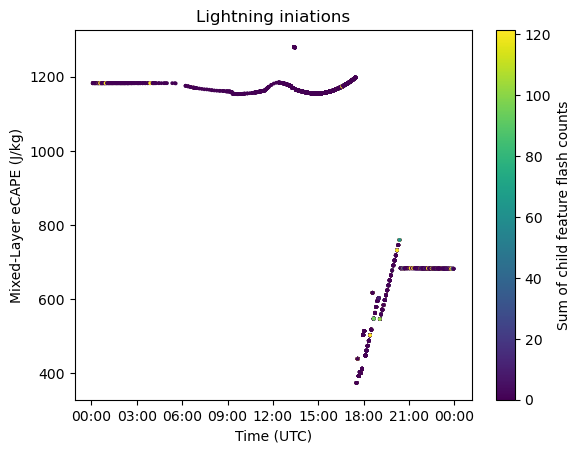

In [21]:
fig, ax = plt.subplots()
for track in track_ds_side.track:
    this_track = track_ds_side.sel(track=track)
    sct = ax.scatter(this_track.time, this_track.track_mlecape, c=this_track.track_flash_count, s=3, label='Mixed-Layer eCAPE')
ax.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M'))
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Mixed-Layer eCAPE (J/kg)')
ax.set_title('Lightning iniations')
fig.colorbar(sct, label='Sum of child feature flash counts')

# ax.scatter(track_ds_side.time.data, track_ds_side.track_flash_count)